# SetUp

In [1]:
import numpy as np
import torch
import torchmetrics
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
# from torch.autograd import Variable

# import copy
# from tqdm import tqdm

from torch.utils.data import SubsetRandomSampler
from sklearn.model_selection import train_test_split

In [38]:
from gromo.linear_growing_module import LinearAdditionGrowingModule, LinearGrowingModule
from gromo.graph_network.GrowableDAG import GrowableDAG
from gromo.graph_network.dag_growing_network import GraphGrowingNetwork
from gromo.utils import utils

In [3]:
def legend():
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
# torch.manual_seed()

# DATA

In [6]:
all_transforms = transforms.Compose([
                                    transforms.Resize((28,28)),
                                    #  transforms.Resize((32,32)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,)),
                                    transforms.Lambda(lambda x: torch.flatten(x)),
                                     ])
# # Create Training dataset
# train_dataset = torchvision.datasets.CIFAR10(root = './data',
#                                              train = True,
#                                              transform = all_transforms,
#                                              download = True)

# # Create Testing dataset
# test_dataset = torchvision.datasets.CIFAR10(root = './data',
#                                             train = False,
#                                             transform = all_transforms,
#                                             download=True)

# Create Training dataset
train_dataset = torchvision.datasets.MNIST(root = './../data',
                                             train = True,
                                             transform = all_transforms,
                                             download = True)

# Create Testing dataset
test_dataset = torchvision.datasets.MNIST(root = './../data',
                                            train = False,
                                            transform = all_transforms,
                                            download=True)


indices = list(range(len(train_dataset.data)))
train_indices, val_indices = train_test_split(indices, test_size=0.1, stratify=train_dataset.targets)

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

# Instantiate loader objects to facilitate processing
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = 256,
                                           sampler = train_sampler)

valid_loader = torch.utils.data.DataLoader(train_dataset, 
                                        batch_size = 128, 
                                        sampler = valid_sampler)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = 256,
                                           shuffle = True)

# Models

In [7]:
def apply_initialization(self):
    for layer in self.modules():
        if isinstance(layer, nn.Linear):
            # Custom weight initialization: 
            # Ensure weights are initialized symmetrically for each output node
            torch.nn.init.orthogonal_(layer.weight)
            # torch.nn.init.kaiming_uniform_(layer.weight, a=0, nonlinearity='selu')
            # torch.nn.init.xavier_uniform_(layer.weight)
            # Bias is initialized to zero or you can use a small constant
            if layer.bias is not None:
                torch.nn.init.zeros_(layer.bias)

In [8]:
class LinearClassicTwoLayers(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, **kwargs):
      super(LinearClassicTwoLayers, self).__init__()
      self.flatten = nn.Flatten()
      self.fc1 = nn.Linear(input_size, hidden_size)
      self.relu = nn.SELU()
      self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self,x):
        x = self.flatten(x)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [9]:
class GroMoNetTwoLayers(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, **kwargs):
        super(GroMoNetTwoLayers, self).__init__()
        self.flatten = nn.Flatten()
        self.start = LinearAdditionGrowingModule(in_features=input_size)
        self.alpha = LinearGrowingModule(in_features=input_size, out_features=hidden_size)
        self.node1 = LinearAdditionGrowingModule(in_features=hidden_size, post_addition_function=nn.SELU())
        self.omega = LinearGrowingModule(in_features=hidden_size, out_features=num_classes)
        self.end = LinearAdditionGrowingModule(in_features=num_classes)

        self.start.set_next_modules([self.alpha])
        self.alpha.previous_module = self.start
        self.alpha.next_module = self.node1
        self.node1.set_previous_modules([self.alpha])
        self.node1.set_next_modules([self.omega])
        self.omega.previous_module = self.node1
        self.omega.next_module = self.end
        self.end.set_previous_modules([self.omega])
    
    def forward(self, x):
        x = self.flatten(x)
        out = self.start(x)
        out = self.alpha(out)
        out = self.node1(out)
        out = self.omega(out)
        out = self.end(out)
        return out

In [10]:
class GroMoNetOneLayer(nn.Module):
    def __init__(self, input_size, num_classes, **kwargs):
        super(GroMoNetOneLayer, self).__init__()
        self.flatten = nn.Flatten()
        self.start = LinearAdditionGrowingModule(in_features=input_size)
        self.alpha = LinearGrowingModule(in_features=input_size, out_features=num_classes)
        self.end = LinearAdditionGrowingModule(in_features=num_classes)

        self.start.set_next_modules([self.alpha])
        self.alpha.previous_module = self.start
        self.alpha.next_module = self.end
        self.end.set_previous_modules([self.alpha])
    
    def forward(self, x):
        x = self.flatten(x)
        out = self.start(x)
        out = self.alpha(out)
        out = self.end(out)
        return out

# Training function

In [53]:
def teaching(teacher_model, student_class, student_args, input_size, batch_size, lr=1e-3, epochs=200, seeds=5):
    print(f"Teacher {teacher_model}")
    print(f"Student {student_class.__name__}")

    # Create datasets from teacher network
    X_train = torch.rand((batch_size, input_size), device=device)
    X_dev = torch.rand((batch_size, input_size), device=device)
    X_val = torch.rand((batch_size, input_size), device=device)
    Y_train = teacher_model(X_train).argmax(axis=1)
    Y_dev = teacher_model(X_dev).argmax(axis=1)
    Y_val = teacher_model(X_val).argmax(axis=1)

    expected_classes = np.arange(student_args["num_classes"])
    unique_classes, counts = torch.unique(Y_train, return_counts=True)
    class_counts = {int(cls): 0 for cls in expected_classes}
    for cls, count in zip(unique_classes.cpu(), counts.cpu()):
        class_counts[int(cls)] = int(count)
    print(class_counts)
    fig = plt.figure()
    im = plt.imshow([list(class_counts.values())], cmap='hot', vmin=0)
    plt.xticks(expected_classes)
    plt.yticks([])
    plt.colorbar(im, orientation='horizontal')
    plt.show()

    loss_function = nn.CrossEntropyLoss()
    
    res = {
        "loss_train": {},
        "acc_train": {},
        "acc_val": {},
    }
    for seed in range(seeds):
        print(f"Seed {seed}")
        losses_train, accs_train, accs_val = [], [], []
        # Create random student model instance
        student_model = student_class(**student_args).to(device)
        optimizer = torch.optim.Adam(student_model.parameters(), lr=lr)

        # for epoch in range(epochs):
        #     images = X_train.to(device)
        #     labels = Y_train.to(device)
            
        #     optimizer.zero_grad()
        #     outputs = student_model(images)
        #     loss = loss_function(outputs, labels)
        #     loss.backward()
        #     optimizer.step()
        #     losses_train.append(loss.item())
            
        #     if ((epoch+1) % 500 == 0) or (epoch+1 == epochs):
        #         print('Epoch [%d/%d],Loss: %.4f' %(epoch+1, epochs, loss.item()))
        
        #     # Evaluation
        #     _, predicted = torch.max(outputs,1)
        #     correct = (predicted == labels).sum()
        #     total = labels.size(0)
        #     acc_train = (100*correct)/(total+1)
        #     accs_train.append(acc_train.item())
        
        #     images = X_val.to(device)
        #     labels = Y_val.to(device)
        def forward_fn():
            return student_net(images)
        def eval_fn():
            output = student_model(images)
            _, predicted = torch.max(output,1)
            correct = (predicted == labels).sum()
            total = labels.size(0)
            acc_val = (100*correct)/(total+1)
            # accs_val.append(acc_val.item())
            return [acc_val]
        
        loss_history, acc_history = utils.batch_gradient_descent(
            forward_fn=forward_fn,
            cost_fn=loss_function,
            target=labels,
            optimizer=optimizer,
            max_epochs=epochs,
            fast=False,
            eval_fn=eval_fn,
            verbose=False,
        )

        print('Train Accuracy of the model: %.3f %%' %acc_history[-1][0])
        print('Validation Accuracy of the model: %.3f %%' %acc_history[-1][1])
        res["loss_train"][seed] = loss_history
        res["acc_train"][seed] = acc_history[:,0]
        res["acc_val"][seed] = np.array(acc_history.cpu())[:,1]
    
    confmat = torchmetrics.classification.ConfusionMatrix(
                task="multiclass", num_classes=student_args["num_classes"]
            ).to(device)
    confmat(predicted, labels)
    fig = plt.figure()
    confmat.plot()
    
    return student_model, res

# Teacher-Student Experiments

In [12]:
input_size = 784
hidden_size = 100
output_size = 5
args = {
    "input_size": input_size, 
    "hidden_size": hidden_size, 
    "num_classes": output_size
    }
batch_size = 20_000

## Replicating nn.Linear with 2 layers

In [33]:
teacher_net = LinearClassicTwoLayers(input_size, hidden_size, output_size).to(device)
apply_initialization(teacher_net)
print(teacher_net)

LinearClassicTwoLayers(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu): SELU()
  (fc2): Linear(in_features=100, out_features=5, bias=True)
)


### With nn.Module

Teacher LinearClassicTwoLayers(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu): SELU()
  (fc2): Linear(in_features=100, out_features=5, bias=True)
)
Student LinearClassicTwoLayers
{0: 1, 1: 7531, 2: 494, 3: 2, 4: 11972}


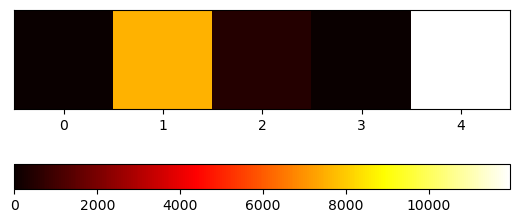

Seed 0
Train Accuracy of the model: 0.648 %
Validation Accuracy of the model: 21.439 %


TypeError: list indices must be integers or slices, not tuple

In [54]:
mod, res_linear_to_linear = teaching(teacher_net, LinearClassicTwoLayers, args, input_size=input_size, batch_size=batch_size)

### With GrowingModule

Teacher LinearClassicTwoLayers(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu): SELU()
  (fc2): Linear(in_features=100, out_features=5, bias=True)
)
Student GroMoNetTwoLayers
{0: 3809, 1: 564, 2: 2668, 3: 3768, 4: 9191}


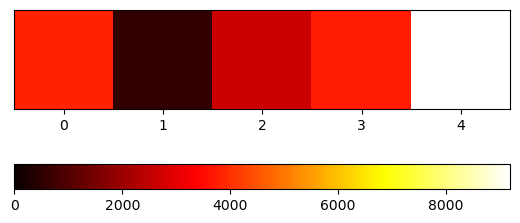

Seed 0
Epoch [200/200],Loss: 0.4786
Train Accuracy of the model: 88.976 %
Validation Accuracy of the model: 84.141 %
Seed 1
Epoch [200/200],Loss: 0.4585
Train Accuracy of the model: 87.091 %
Validation Accuracy of the model: 85.611 %
Seed 2
Epoch [200/200],Loss: 0.4656
Train Accuracy of the model: 87.191 %
Validation Accuracy of the model: 84.736 %
Seed 3
Epoch [200/200],Loss: 0.4466
Train Accuracy of the model: 90.390 %
Validation Accuracy of the model: 83.286 %
Seed 4
Epoch [200/200],Loss: 0.4037
Train Accuracy of the model: 91.190 %
Validation Accuracy of the model: 84.996 %


<Figure size 640x480 with 0 Axes>

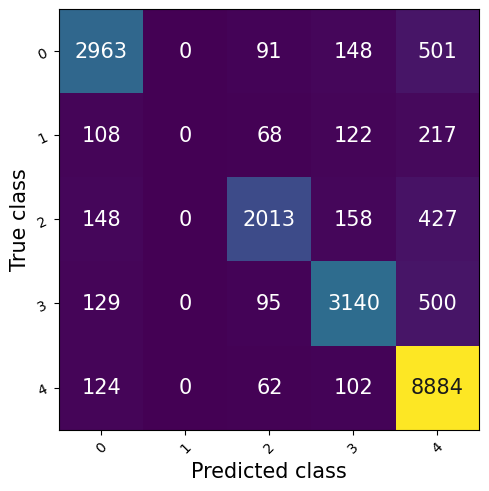

In [15]:
mod, res_linear_to_gromo = teaching(teacher_net, GroMoNetTwoLayers, args, input_size, batch_size)

### Results

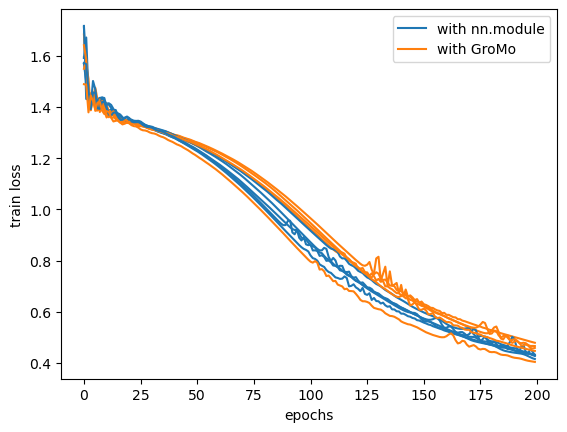

In [16]:
for i in range(5):
    plt.plot(res_linear_to_linear["loss_train"][i], c=colors[0], label="with nn.module")
    plt.plot(res_linear_to_gromo["loss_train"][i], c=colors[1], label="with GroMo")
legend()
plt.xlabel("epochs")
plt.ylabel("train loss")
plt.show()

## Replicating GrowingModule with 1 layer

GroMoNetOneLayer(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (start): LinearAdditionGrowingModule module with no previous modules and 1 next modules.
  (alpha): LinearGrowingModule(in_features=784, out_features=5, use_bias=True)
  (end): LinearAdditionGrowingModule module with 1 previous modules and no next modules.
)
{0: 717, 1: 80, 2: 6394, 3: 7844, 4: 4965}


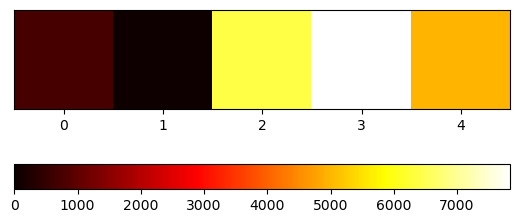

In [25]:
teacher_net = GroMoNetOneLayer(input_size, output_size).to(device)
apply_initialization(teacher_net)
print(teacher_net)
X_train = torch.rand((batch_size, input_size), device=device)
X_dev = torch.rand((batch_size, input_size), device=device)
X_val = torch.rand((batch_size, input_size), device=device)
Y_train = teacher_net(X_train).argmax(axis=1)
Y_dev = teacher_net(X_dev).argmax(axis=1)
Y_val = teacher_net(X_val).argmax(axis=1)
expected_classes = np.arange(output_size)
unique_classes, counts = torch.unique(Y_train, return_counts=True)
class_counts = {int(cls): 0 for cls in expected_classes}
for cls, count in zip(unique_classes.cpu(), counts.cpu()):
    class_counts[int(cls)] = int(count)
print(class_counts)
fig = plt.figure()
im = plt.imshow([list(class_counts.values())], cmap='hot', vmin=0)
plt.xticks(expected_classes)
plt.yticks([])
plt.colorbar(im, orientation='horizontal')
plt.show()

### With GrowingModules

Teacher GroMoNetOneLayer(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (start): LinearAdditionGrowingModule module with no previous modules and 1 next modules.
  (alpha): LinearGrowingModule(in_features=784, out_features=5, use_bias=True)
  (end): LinearAdditionGrowingModule module with 1 previous modules and no next modules.
)
Student GroMoNetOneLayer
{0: 708, 1: 60, 2: 6428, 3: 7760, 4: 5044}


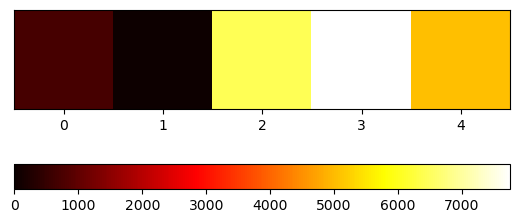

Seed 0
Epoch [200/200],Loss: 0.8756
Train Accuracy of the model: 81.031 %
Validation Accuracy of the model: 78.496 %
Seed 1
Epoch [200/200],Loss: 0.8446
Train Accuracy of the model: 80.781 %
Validation Accuracy of the model: 79.161 %
Seed 2
Epoch [200/200],Loss: 0.8323
Train Accuracy of the model: 82.961 %
Validation Accuracy of the model: 80.476 %
Seed 3
Epoch [200/200],Loss: 0.8182
Train Accuracy of the model: 82.981 %
Validation Accuracy of the model: 80.681 %
Seed 4
Epoch [200/200],Loss: 0.8604
Train Accuracy of the model: 82.386 %
Validation Accuracy of the model: 80.096 %


<Figure size 640x480 with 0 Axes>

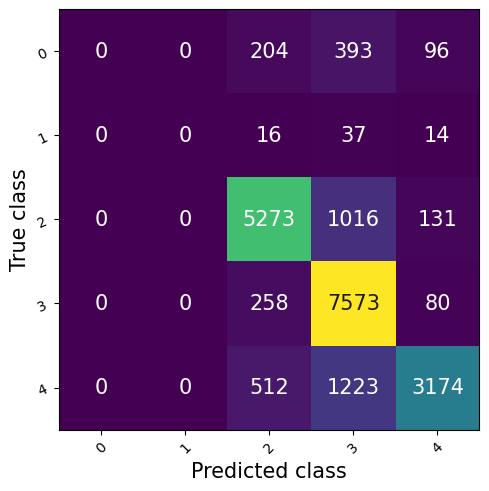

In [26]:
mod, res_gromo_to_gromo_1layer = teaching(teacher_net, GroMoNetOneLayer, args, input_size, batch_size)

### With GraphNetwork

In [27]:
def get_generations(dag):
    direct_edges, one_hop_edges = dag.find_possible_extensions()
    generations = []
    # All possible new direct edges
    for attr in direct_edges:
        previous_node = attr.get("previous_node")
        next_node = attr.get("next_node")
        edge_name = f"l{previous_node}_{next_node}"
        gen = {
            "type": "edge",
            "attributes": attr,
            "id": edge_name,
            "evolved": False,
        }
        generations.append(gen)

    # All possible one-hop connections
    for attr in one_hop_edges:
        previous_node = attr.get("previous_node")
        new_node = attr.get("new_node")
        next_node = attr.get("next_node")
        new_edges = [
            (previous_node, new_node),
            (new_node, next_node),
        ]
        attr["new_edges"] = new_edges

        gen = {
            "type": "node",
            "attributes": attr,
            "id": new_node,
            "evolved": False,
        }
        generations.append(gen)

    # All existing nodes
    for node in dag.nodes:
        if (node == dag.root) or (node == dag.end):
            continue

        previous_nodes = [n for n in dag.predecessors(node)]
        next_nodes = [n for n in dag.successors(node)]

        new_edges = [in_edge for in_edge in dag.in_edges(node)]
        new_edges.extend([out_edge for out_edge in dag.out_edges(node)])

        attr = {
            "new_node": node,
            "previous_node": previous_nodes,
            "next_node": next_nodes,
            "new_edges": new_edges,
        }
        gen = {
            "type": "node",
            "attributes": attr,
            "id": node,
            "evolved": False,
        }
        generations.append(gen)
    return generations
        
def calculate_metrics(self):
    generations = self.define_next_generations()

    constant_module = False
    if self.dag.is_empty():
        constant_module = True
        edge_attributes = {"type": "L", "use_bias": self.use_bias, "constant": True}
        self.dag.add_direct_edge("start", "end", edge_attributes)

    prev_node_modules = set()
    next_node_modules = set()
    for gen in generations:
        attributes = gen.get("attributes")

        prev_node = attributes.get("previous_node")
        next_node = attributes.get("next_node")
        if not isinstance(prev_node, list):
            prev_node = [prev_node]
        if not isinstance(next_node, list):
            next_node = [next_node]

        prev_node_modules.update(prev_node)
        next_node_modules.update(next_node)

    # new_node_modules = self.dag.get_node_modules(new_node_modules)
    prev_node_modules = self.dag.get_node_modules(prev_node_modules)
    next_node_modules = self.dag.get_node_modules(next_node_modules)
    for node_module in prev_node_modules:
        node_module.store_activity = True
    for node_module in next_node_modules:
        node_module.init_computation()

    # Forward - Backward step
    pred = self(X_train)
    loss = self.loss_fn(pred, Y_train)
    loss.backward()

    input_B = {}
    bottleneck = {}

    # Update tensors
    for node_module in next_node_modules:
        node_module.previous_tensor_s.update()
        node_module.previous_tensor_m.update()

        # Compute optimal possible updates
        node_module.compute_optimal_delta(update=True, return_deltas=False)

        # Compute expressivity bottleneck
        bottleneck[node_module.name] = (
            node_module.projected_v_goal().clone().detach()
        )  # (batch_size, out_features)

        if constant_module:
            assert torch.all(
                bottleneck[node_module.name] == node_module.pre_activity.grad
            ), "Graph is empty and the bottleneck should be the same as the pre_activity gradient. Expected: {node_module.pre_activity.grad} Found: {bottleneck[node_module.name]}"

        # Reset tensors and remove hooks
        node_module.reset_computation()

    for node_module in prev_node_modules:
        # Save input activity of input layers
        input_B[node_module.name] = node_module.activity.clone().detach()

        # Reset tensors and remove hooks
        node_module.store_activity = False
        
    # Reset all hooks
    for next_node_module in next_node_modules:
        for parallel_module in next_node_module.previous_modules:
            parallel_module.reset_computation()
            # DO NOT delete updates
            # parallel_module.delete_update()
        # Delete activities
        next_node_module.delete_update()

    if constant_module:
        self.dag.remove_direct_edge("start", "end")
    
    return bottleneck, input_B

Mlflow tracking at file:///home/sdouka/Documents/tiny.worktrees/GroMo/temp/mlruns
Mlflow tracking at file:///home/sdouka/Documents/tiny.worktrees/GroMo/temp/mlruns
1.579668402671814 1.579357624053955 0.35599997639656067 0.3565499782562256
Train Accuracy of the model: 35.600 %
Development Accuracy of the model: 66.495 %
Validation Accuracy of the model: 64.967 %
Mlflow tracking at file:///home/sdouka/Documents/tiny.worktrees/GroMo/temp/mlruns
1.591506004333496 1.590794563293457 0.3246999979019165 0.3301999866962433
Train Accuracy of the model: 32.470 %
Development Accuracy of the model: 66.305 %
Validation Accuracy of the model: 64.517 %
Mlflow tracking at file:///home/sdouka/Documents/tiny.worktrees/GroMo/temp/mlruns
1.6177424192428589 1.6169676780700684 0.22154998779296875 0.22679999470710754
Train Accuracy of the model: 22.155 %
Development Accuracy of the model: 65.745 %
Validation Accuracy of the model: 64.202 %
Mlflow tracking at file:///home/sdouka/Documents/tiny.worktrees/GroMo/

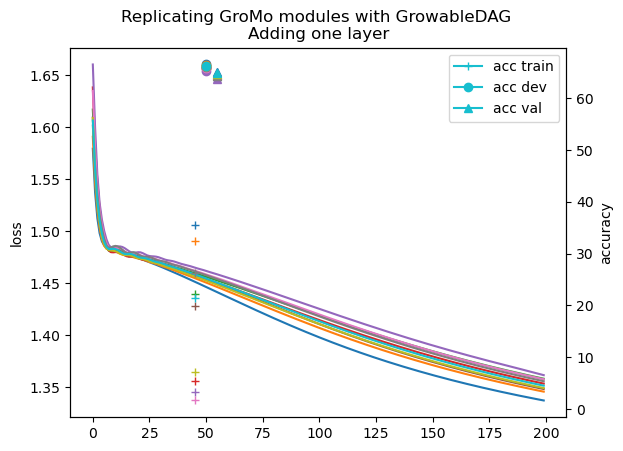

In [28]:
res_gromo_to_graph_1layer = {
    "b_loss_train": [],
    "loss_dev": [],
    "acc_train": [],
    "acc_dev": [],
    "acc_val": [],
}
start = "start"
end = "end"

student_net = GraphGrowingNetwork(input_size, output_size, neurons=hidden_size)
bottleneck, input_B = calculate_metrics(student_net)

for seed in range(10):
    student_net = GraphGrowingNetwork(input_size, output_size, neurons=hidden_size)
    student_net.dag.add_direct_edge(start, end, {})
    loss_train, loss_dev, acc_train, acc_dev, res = (
                    student_net.update_edge_weights(
                        prev_node=start,
                        next_node=end,
                        bottlenecks=bottleneck,
                        activities=input_B,
                        x=X_train,
                        y=Y_train,
                        x1=X_dev,
                        y1=Y_dev,
                        amplitude_factor=False,
                        verbose=False,
                    )
                )
    print(loss_train, loss_dev, acc_train, acc_dev)

    # TODO: intermediate training
    hist_loss_dev, hist_acc_dev = student_net.inter_training(
            X_dev, Y_dev, X_val, Y_val, verbose=False
        )
    acc_dev = hist_acc_dev[-1][0]

    # Evaluation
    images = X_val.to(device)
    labels = Y_val.to(device)

    output = student_net(images)
    _, predicted = torch.max(output,1)
    correct = (predicted == labels).sum()
    total = labels.size(0)
    acc_val = (correct/(total+1)).item()
    print('Train Accuracy of the model: %.3f %%' %(acc_train*100))
    print('Development Accuracy of the model: %.3f %%' %(acc_dev*100))
    print('Validation Accuracy of the model: %.3f %%' %(acc_val*100))

    res_gromo_to_graph_1layer["b_loss_train"].append(res) # this is the bottleneck loss!!!
    res_gromo_to_graph_1layer["loss_dev"].append(hist_loss_dev)
    res_gromo_to_graph_1layer["acc_train"].append(acc_train*100)
    res_gromo_to_graph_1layer["acc_dev"].append(acc_dev*100)
    res_gromo_to_graph_1layer["acc_val"].append(acc_val*100)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
for i in range(len(res_gromo_to_graph_1layer["b_loss_train"])):
    # ax1.plot(res_gromo_to_graph_1layer["b_loss_train"][i], c=colors[i], label='bottleneck loss train')
    ax1.plot(res_gromo_to_graph_1layer["loss_dev"][i], c=colors[i], label='loss dev')
    ax2.plot(45, res_gromo_to_graph_1layer["acc_train"][i], marker='+', c=colors[i], label='acc train')
    ax2.plot(50, res_gromo_to_graph_1layer["acc_dev"][i], marker='o', c=colors[i], label='acc dev')
    ax2.plot(55, res_gromo_to_graph_1layer["acc_val"][i], marker='^', c=colors[i], label='acc val')
legend()
ax1.set_ylabel("loss")
ax2.set_ylabel("accuracy")
plt.title(f"Replicating GroMo modules with GrowableDAG \nAdding one layer")
plt.show()
plt.show()

In [29]:
res_gromo_to_graph_1layer.keys()

dict_keys(['b_loss_train', 'loss_dev', 'acc_train', 'acc_dev', 'acc_val'])

### Results

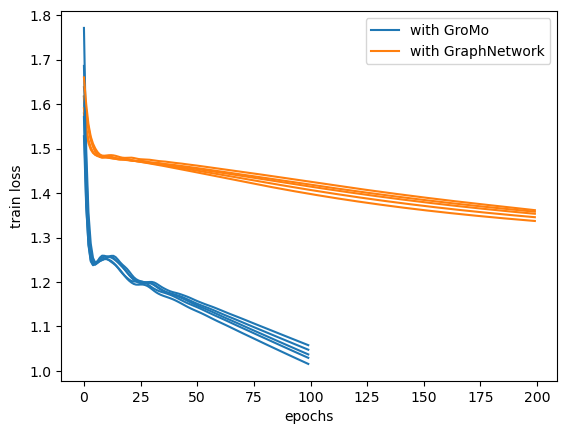

In [30]:
for i in range(5):
    plt.plot(res_gromo_to_gromo_1layer["loss_train"][i][:100], c=colors[0], label="with GroMo")
    plt.plot(res_gromo_to_graph_1layer["loss_dev"][i], c=colors[1], label="with GraphNetwork")
legend()
plt.xlabel("epochs")
plt.ylabel("train loss")
plt.show()

## Replicating GrowingModule with 2 layers

In [31]:
pass